## Structure
- Eda and data preprocessing
- Basic model + CV
- Fairness metrics
- Pre-processing (no protected features)
- FairPCA
- In-processing fairness
- Post-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score, roc_curve, recall_score
)
from scipy.stats import pearsonr
import scipy.linalg
import scipy.optimize as opt

# Functions

In [2]:

def plot_bar_distribution(data, column, labels=None, title="", xlabel="", ylabel="", rotation=0):
    counts = data[column].value_counts().sort_index()
    if labels:
        counts.index = labels
    counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_group_metrics(group_metrics, group_labels, title):
    metrics = ["Accuracy", "BalancedAccuracy", "F1", "PositiveRate"]
    plot_data = []
    for metric in metrics:
        row = [np.mean(group_metrics[metric][g]) for g in group_labels]
        plot_data.append(row)
    plot_data = np.array(plot_data)
    x = np.arange(len(metrics))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))
    bars1 = ax.bar(x - width/2, plot_data[:, 0], width, label=group_labels[0], color='#1E90FF')
    bars2 = ax.bar(x + width/2, plot_data[:, 1], width, label=group_labels[1], color='#FF8C00')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.legend()
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_fairness(fair_gender, fair_age):
    fig, ax = plt.subplots(1, 2, figsize=(11, 5), sharey=True)
    sns.barplot(data=fair_gender, x="Metric", y="Score", hue="Group", ax=ax[0])
    ax[0].set_title("Fairness Metrics by Gender")
    ax[0].set_ylabel("Rate")
    ax[0].set_xlabel("")
    ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
    sns.barplot(data=fair_age, x="Metric", y="Score", hue="Group", ax=ax[1])
    ax[1].set_title("Fairness Metrics by Age")
    ax[1].set_ylabel("")
    ax[1].set_xlabel("")
    ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
    plt.tight_layout()
    plt.show()

In [5]:
def compute_fairness_metrics(pred, true, group_feature, group_names=("Group 0", "Group 1")):
    def stat_parity(pred, group_feature):
        group0 = np.mean(pred[group_feature == 0])
        group1 = np.mean(pred[group_feature == 1])
        return group0, group1
    def equal_odds(pred, true, group_feature, target_label):
        mask_0 = (true == target_label) & (group_feature == 0)
        mask_1 = (true == target_label) & (group_feature == 1)
        group0 = np.mean(pred[mask_0]) if mask_0.sum() > 0 else np.nan
        group1 = np.mean(pred[mask_1]) if mask_1.sum() > 0 else np.nan
        return group0, group1
    scores = [
        stat_parity(pred, group_feature),
        equal_odds(pred, true, group_feature, target_label=0),
        equal_odds(pred, true, group_feature, target_label=1),
    ]
    metric_names = ["Statistical Parity", "FPR (Equalized Odds)", "TPR (Equalized Odds)"]
    rows = []
    for metric, (g0, g1) in zip(metric_names, scores):
        rows.append({"Metric": metric, "Group": group_names[0], "Score": g0})
        rows.append({"Metric": metric, "Group": group_names[1], "Score": g1})
    return pd.DataFrame(rows)

In [6]:
def plot_top_features(importances_df, title):
    plt.figure(figsize=(8, 6))
    sns.barplot(data=importances_df.head(10), x="Weight", y="Feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# EDA and data preprocessing

In [7]:
data = pd.read_csv("data.csv", sep=";")
data.columns = data.columns.str.strip().str.replace('\t', '', regex=False)
data.head()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [8]:
data.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd s

In [9]:
# Drop not needed columns
data = data.drop(columns=["Nacionality", "Application mode","Previous qualification (grade)",
       'Mother\'s occupation', 'Father\'s occupation','Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', "Tuition fees up to date",'Unemployment rate', 'Inflation rate', 'GDP'], axis=1)

In [10]:
# Filter target
data = data[data["Target"] != "Enrolled"]
data["Target"] = data["Target"].map({"Graduate": 1, "Dropout": 0})
data.Target.value_counts()



1    2209
0    1421
Name: Target, dtype: int64

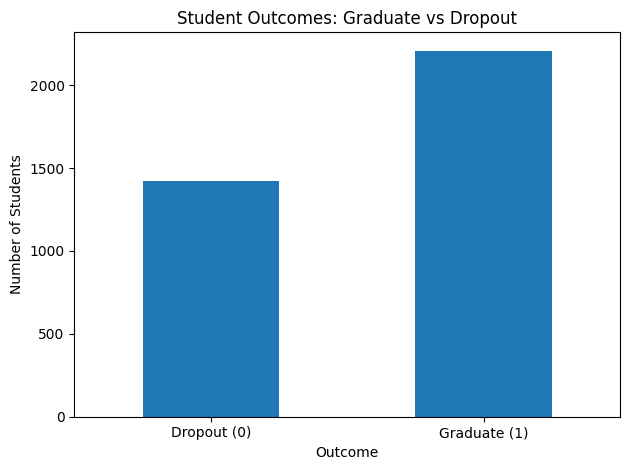

In [11]:
# Plot target distribution
plot_bar_distribution(
    data, "Target", labels=["Dropout (0)", "Graduate (1)"],
    title="Student Outcomes: Graduate vs Dropout",
    xlabel="Outcome", ylabel="Number of Students"
)

In [12]:
# Convert gender to int and plot
data["Gender"] = data["Gender"].astype(int)
data.Gender.value_counts()

0    2381
1    1249
Name: Gender, dtype: int64

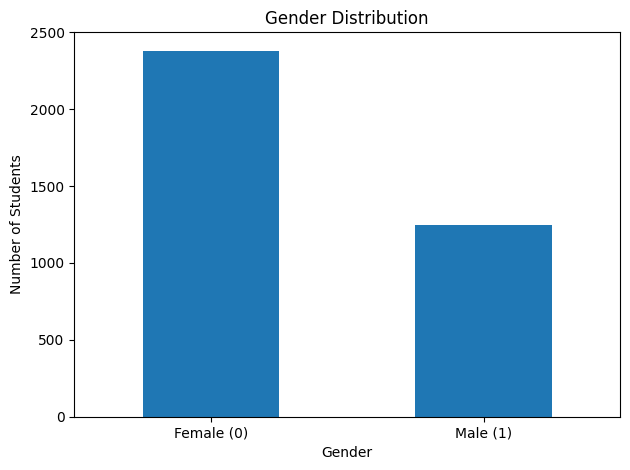

In [13]:
plot_bar_distribution(
    data, "Gender", labels=["Female (0)", "Male (1)"],
    title="Gender Distribution",
    xlabel="Gender", ylabel="Number of Students"
)

In [14]:
# Parent education
higher_education = {2, 3, 4, 5, 6, 40, 41, 42, 43, 44}
data['mother_education'] = data["Mother's qualification"].apply(lambda x: 1 if x in higher_education else 0)
data['father_education'] = data["Father's qualification"].apply(lambda x: 1 if x in higher_education else 0)
data.drop(columns=["Father's qualification", "Mother's qualification"], inplace=True)

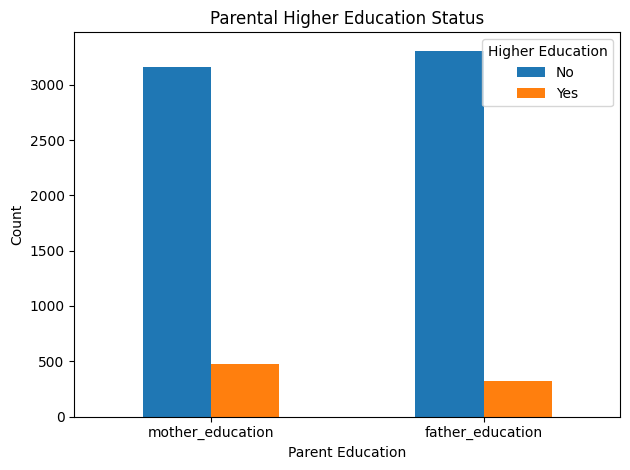

In [15]:
# Plot parent education
edu_counts = data[['mother_education', 'father_education']].apply(pd.Series.value_counts).T
edu_counts.plot(kind='bar')
plt.title("Parental Higher Education Status")
plt.xlabel("Parent Education")
plt.ylabel("Count")
plt.legend(title="Higher Education", labels=["No", "Yes"], loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
# Merge courses and label
merge_map = {8014: 9238, 9991: 9147}
data["Course"] = data["Course"].replace(merge_map)
course_map = {
    33: "Biofuel Production Technologies", 171: "Animation and Multimedia Design",
    9003: "Agronomy", 9070: "Communication Design", 9085: "Veterinary Nursing",
    9119: "Informatics Engineering", 9130: "Equinculture", 9147: "Management",
    9238: "Social Service", 9254: "Tourism", 9500: "Nursing", 9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management", 9773: "Journalism and Communication",
    9853: "Basic Education"
}
data["course_name"] = data["Course"].map(course_map)
data.drop("Course", axis=1, inplace=True)

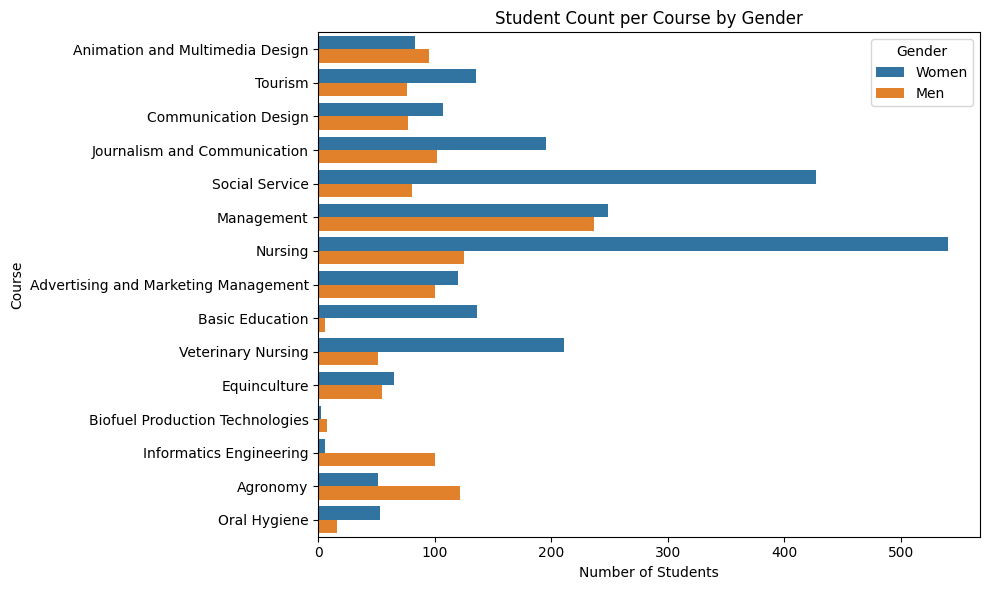

In [17]:
# Plot course distribution by gender
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y="course_name", hue="Gender")
plt.title("Student Count per Course by Gender")
plt.xlabel("Number of Students")
plt.ylabel("Course")
plt.legend(title="Gender", labels=["Women", "Men"])
plt.tight_layout()
plt.show()

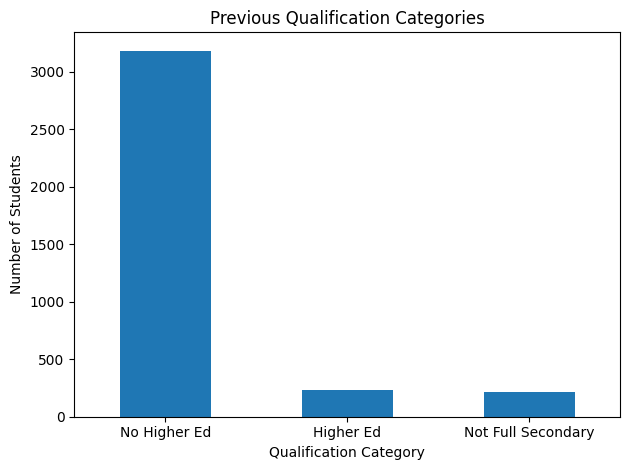

In [18]:
# Previous qualification mapping
already_higher = {2, 3, 4, 5, 6, 40, 42, 43}
no_higher = {1, 39}
non_secondary = {9, 10, 12, 14, 15, 19, 38}

def tri_map(value):
    if value in already_higher:
        return 1
    elif value in no_higher:
        return 0
    elif value in non_secondary:
        return 2
    else:
        return None

data["Previous_qualification"] = data["Previous qualification"].apply(tri_map)
data.drop("Previous qualification", axis=1, inplace=True)
plot_bar_distribution(
    data, "Previous_qualification",
    labels=["No Higher Ed", "Higher Ed", "Not Full Secondary"],
    title="Previous Qualification Categories",
    xlabel="Qualification Category", ylabel="Number of Students"
)

In [19]:
# Application order and age
data["Application order"] = (data["Application order"] == 1).astype(int)
data["Age at enrollment"] = (data["Age at enrollment"] > 23).astype(int)

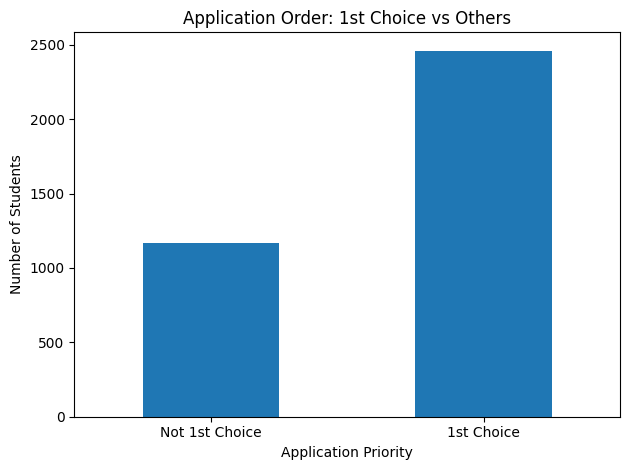

In [20]:
plot_bar_distribution(
    data, "Application order", labels=["Not 1st Choice", "1st Choice"],
    title="Application Order: 1st Choice vs Others",
    xlabel="Application Priority", ylabel="Number of Students"
)

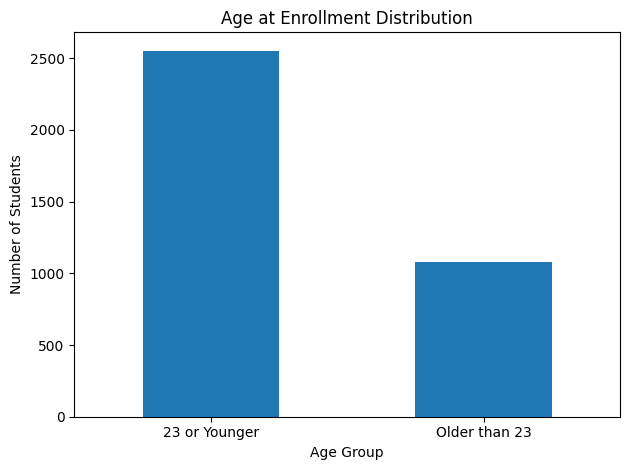

In [21]:
plot_bar_distribution(
    data, "Age at enrollment", labels=["23 or Younger", "Older than 23"],
    title="Age at Enrollment Distribution",
    xlabel="Age Group", ylabel="Number of Students"
)

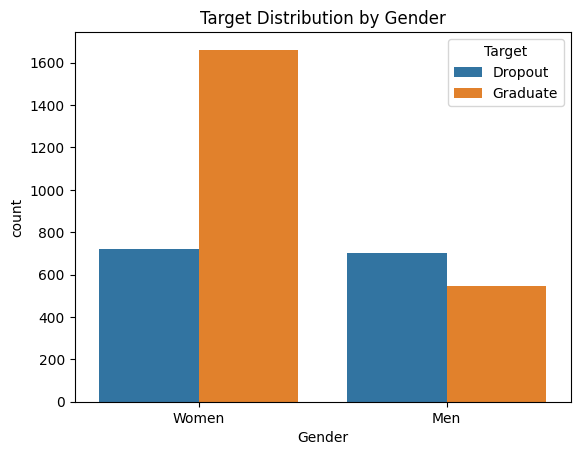

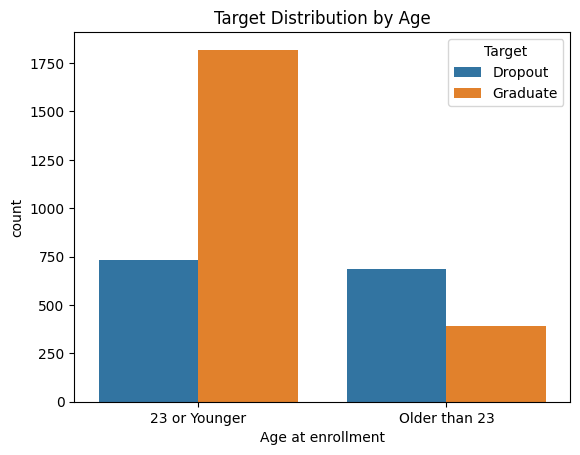

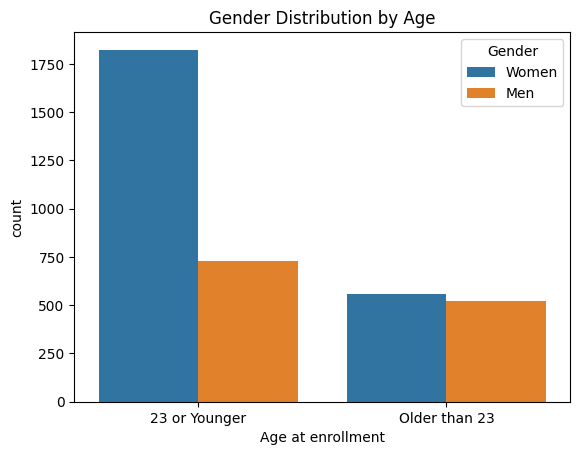

In [22]:
# Grouped bar plots for Target vs Gender and Age
sns.countplot(data=data, x="Gender", hue="Target")
plt.xticks([0, 1], ["Women", "Men"])
plt.title("Target Distribution by Gender")
plt.legend(title="Target", labels=["Dropout", "Graduate"])
plt.show()

sns.countplot(data=data, x="Age at enrollment", hue="Target")
plt.xticks([0, 1], ["23 or Younger", "Older than 23"])
plt.title("Target Distribution by Age")
plt.legend(title="Target", labels=["Dropout", "Graduate"])
plt.show()

sns.countplot(data=data, x="Age at enrollment", hue="Gender")
plt.xticks([0, 1], ["23 or Younger", "Older than 23"])
plt.title("Gender Distribution by Age")
plt.legend(title="Gender", labels=["Women", "Men"])
plt.show()

In [23]:
cols = ["Marital status","course_name", "Previous_qualification"]

df = pd.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)

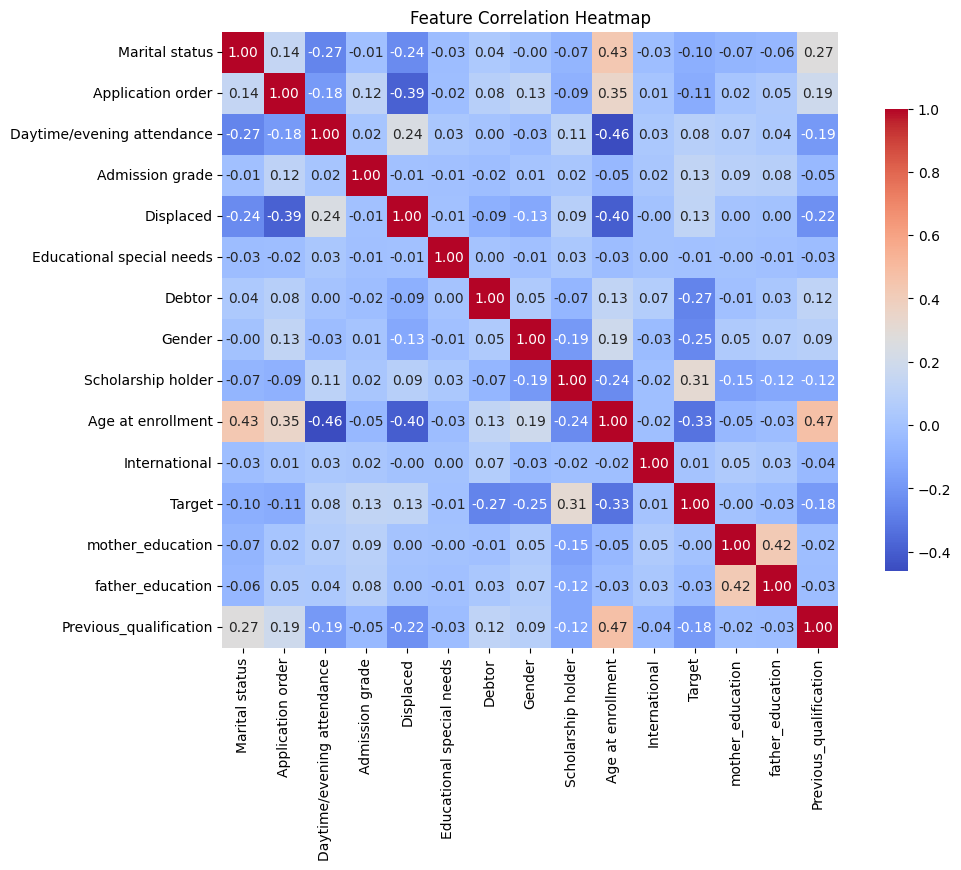

In [24]:
# Calculate correlation matrix
corr_matrix = data.corr(numeric_only=True)
# Set up the matplotlib figure
plt.figure(figsize=(12, 8))
# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .75})
# Set title
plt.title("Feature Correlation Heatmap")
# Show plot
plt.show()

# BASIC MODEL WITH CV

In [25]:
y = df["Target"]
X = df.drop("Target", axis=1)

In [26]:
# Initialize variables
cols_to_scale = ["Admission grade"]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
overall_accuracies = []
overall_f1s = []
group_metrics = {m: {g: [] for g in ["Female", "Male", "Over_23", "Under_23"]} for m in ["F1", "Accuracy", "PositiveRate", "BalancedAccuracy"]}

In [27]:
# Cross-validation loop
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Standardize features
    scaler = StandardScaler().fit(X_train[cols_to_scale])
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
    X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

    # Train model
    model = LogisticRegression(max_iter=5000, penalty=None, solver="saga")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Store overall metrics
    overall_accuracies.append(accuracy_score(y_test, y_pred))
    overall_f1s.append(f1_score(y_test, y_pred))

    # Group evaluation
    group_test_dict = {
        "Female": X_test_scaled["Gender"] == 0,
        "Male": X_test_scaled["Gender"] == 1,
        "Under_23": X_test_scaled["Age at enrollment"] == 0,
        "Over_23": X_test_scaled["Age at enrollment"] == 1
    }
    for group, mask in group_test_dict.items():
        if mask.sum() == 0:
            continue
        group_metrics["F1"][group].append(f1_score(y_test[mask], y_pred[mask]))
        group_metrics["PositiveRate"][group].append(np.mean(y_pred[mask]))
        group_metrics["Accuracy"][group].append(accuracy_score(y_test[mask], y_pred[mask]))
        group_metrics["BalancedAccuracy"][group].append(balanced_accuracy_score(y_test[mask], y_pred[mask]))

In [28]:
# Final model training for visualization
scaler = StandardScaler().fit(X[cols_to_scale])
X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.transform(X[cols_to_scale])
final_model = LogisticRegression(max_iter=5000, penalty=None, solver="saga")
final_model.fit(X_scaled, y)

LogisticRegression(max_iter=5000, penalty=None, solver='saga')

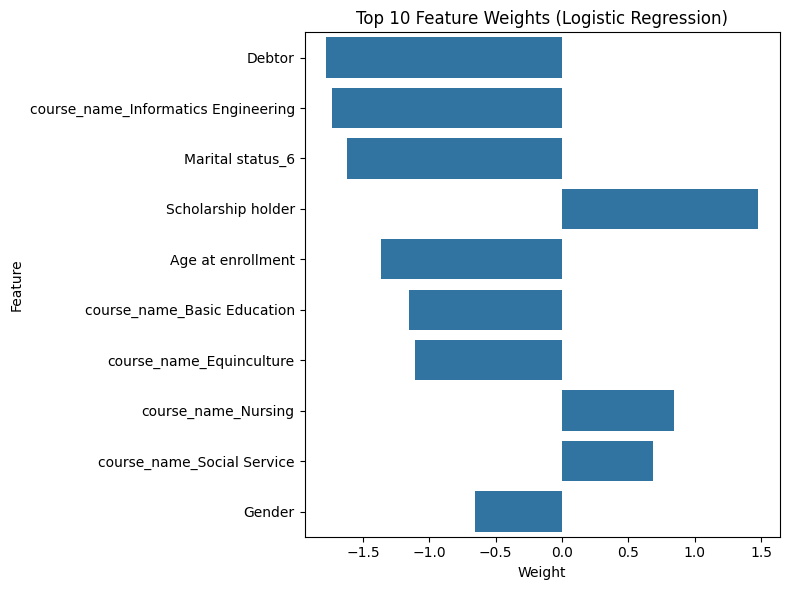

In [29]:
# Plot feature importances
importance_df = pd.DataFrame({
    "Feature": X_scaled.columns,
    "Weight": final_model.coef_[0]
}).sort_values(by="Weight", key=np.abs, ascending=False)
plot_top_features(importance_df, "Top 10 Feature Weights (Logistic Regression)")

Mean Accuracy: 0.7584
Mean F1 Score: 0.8097

--- F1 ---
Female: 0.85
Male: 0.67
Over_23: 0.55
Under_23: 0.86

--- Accuracy ---
Female: 0.78
Male: 0.72
Over_23: 0.71
Under_23: 0.78

--- PositiveRate ---
Female: 0.79
Male: 0.41
Over_23: 0.28
Under_23: 0.82

--- BalancedAccuracy ---
Female: 0.69
Male: 0.71
Over_23: 0.67
Under_23: 0.67


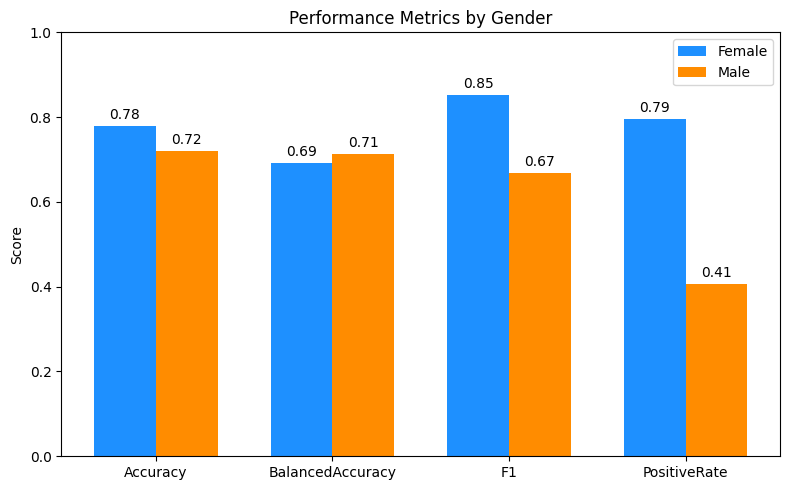

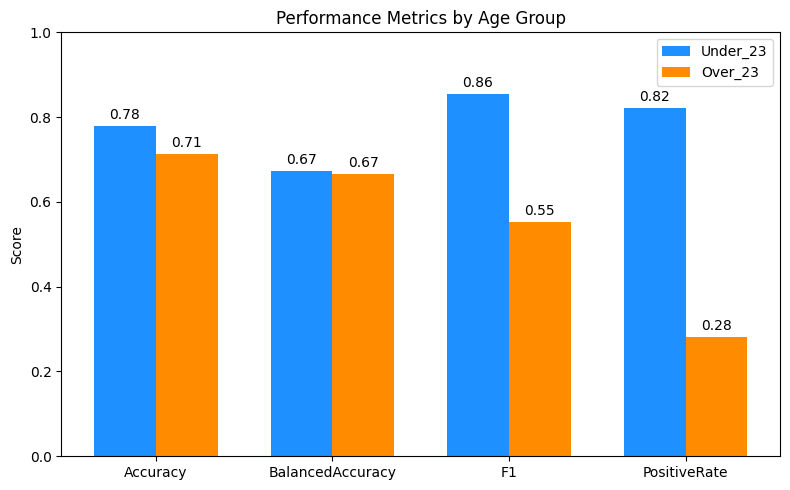

In [30]:
# Print performance metrics
print(f"Mean Accuracy: {np.mean(overall_accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(overall_f1s):.4f}")
# Print group-level metrics
for metric, results in group_metrics.items():
    print(f"\n--- {metric} ---")
    for group, scores in results.items():
        if scores:
            print(f"{group}: {np.mean(scores):.2f}")

# Plot group metrics by gender and age
plot_group_metrics(group_metrics, ["Female", "Male"], "Performance Metrics by Gender")
plot_group_metrics(group_metrics, ["Under_23", "Over_23"], "Performance Metrics by Age Group")

In [31]:
# Store predictions for fairness metrics
y_test_final = y_test
y_pred_final = y_pred
X_test_scaled_final = X_test_scaled

# Fairness metrics

In [32]:
# Compute fairness metrics for Gender and Age groups
fair_gender = compute_fairness_metrics(
    pred=y_pred_final,
    true=y_test_final,
    group_feature=X_test_scaled_final["Gender"],
    group_names=["Female", "Male"]
)
print("Fairness Metrics - Gender:")
print(fair_gender)

fair_age = compute_fairness_metrics(
    pred=y_pred_final,
    true=y_test_final,
    group_feature=X_test_scaled_final["Age at enrollment"],
    group_names=["Under 23", "Over 23"]
)
print("Fairness Metrics - Age:")
print(fair_age)

Fairness Metrics - Gender:
                 Metric   Group     Score
0    Statistical Parity  Female  0.761711
1    Statistical Parity    Male  0.357447
2  FPR (Equalized Odds)  Female  0.470588
3  FPR (Equalized Odds)    Male  0.167939
4  TPR (Equalized Odds)  Female  0.893491
5  TPR (Equalized Odds)    Male  0.596154
Fairness Metrics - Age:
                 Metric     Group     Score
0    Statistical Parity  Under 23  0.812877
1    Statistical Parity   Over 23  0.235808
2  FPR (Equalized Odds)  Under 23  0.530201
3  FPR (Equalized Odds)   Over 23  0.111111
4  TPR (Equalized Odds)  Under 23  0.933908
5  TPR (Equalized Odds)   Over 23  0.414894


C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])


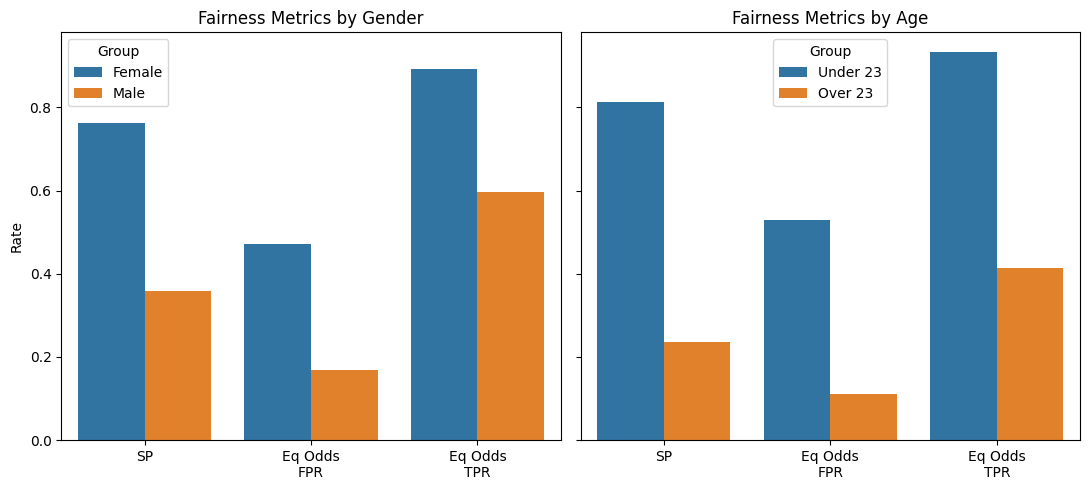

In [33]:
plot_fairness(fair_gender, fair_age)

# Pre-processing model (no protected features)

In [34]:
# Drop protected features
X_no_protected = X.drop(columns=["Gender", "Age at enrollment"])

In [35]:
# Standardize and train final model
scaler_np = StandardScaler().fit(X_no_protected[cols_to_scale])
X_train_np = X_no_protected.copy()
X_train_np[cols_to_scale] = scaler_np.transform(X_no_protected[cols_to_scale])

In [36]:
# Fit model
model_np = LogisticRegression(max_iter=5000, penalty=None, solver="saga")
model_np.fit(X_train_np, y)

LogisticRegression(max_iter=5000, penalty=None, solver='saga')

In [37]:
# Predict on full test set (using protected attributes for fairness check)
X_test_protected = X_test_scaled_final.copy()
X_test_np = X_test_protected.drop(columns=["Gender", "Age at enrollment"])
X_test_np[cols_to_scale] = scaler_np.transform(X_test_np[cols_to_scale])

In [38]:
# Predict and evaluate
y_pred_np = model_np.predict(X_test_np)
acc_np = accuracy_score(y_test_final, y_pred_np)
f1_np = f1_score(y_test_final, y_pred_np)
print(f"Accuracy (No Protected Features): {acc_np:.4f}")
print(f"F1 Score (No Protected Features): {f1_np:.4f}")

Accuracy (No Protected Features): 0.4697
F1 Score (No Protected Features): 0.2406


In [39]:
# Fairness evaluation
fair_gender_np = compute_fairness_metrics(
    pred=y_pred_np,
    true=y_test_final,
    group_feature=X_test_scaled_final["Gender"],
    group_names=["Female", "Male"]
)
print("Fairness (Gender) - No Protected Features:")
print(fair_gender_np)

fair_age_np = compute_fairness_metrics(
    pred=y_pred_np,
    true=y_test_final,
    group_feature=X_test_scaled_final["Age at enrollment"],
    group_names=["Under 23", "Over 23"]
)
print("Fairness (Age) - No Protected Features:")
print(fair_age_np)


Fairness (Gender) - No Protected Features:
                 Metric   Group     Score
0    Statistical Parity  Female  0.120163
1    Statistical Parity    Male  0.025532
2  FPR (Equalized Odds)  Female  0.026144
3  FPR (Equalized Odds)    Male  0.000000
4  TPR (Equalized Odds)  Female  0.162722
5  TPR (Equalized Odds)    Male  0.057692
Fairness (Age) - No Protected Features:
                 Metric     Group     Score
0    Statistical Parity  Under 23  0.128773
1    Statistical Parity   Over 23  0.004367
2  FPR (Equalized Odds)  Under 23  0.026846
3  FPR (Equalized Odds)   Over 23  0.000000
4  TPR (Equalized Odds)  Under 23  0.172414
5  TPR (Equalized Odds)   Over 23  0.010638


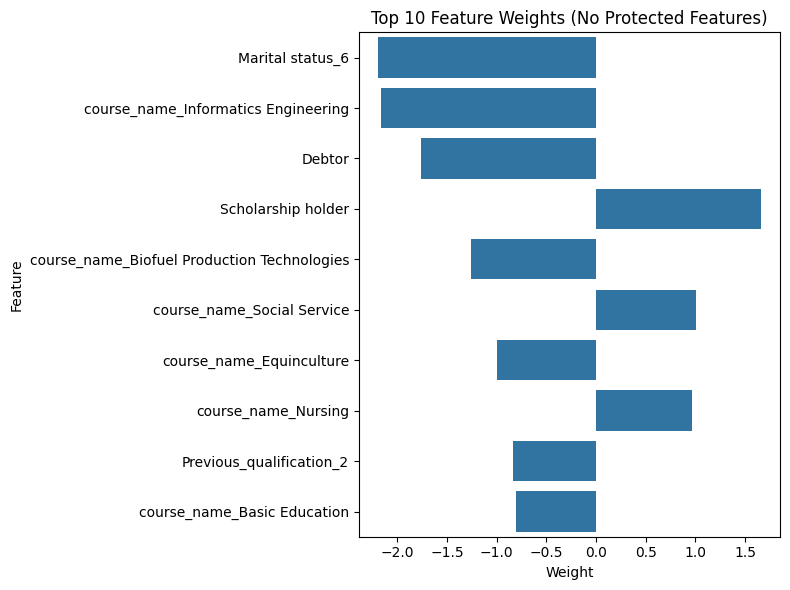

In [40]:
# Feature importance
importance_df_np = pd.DataFrame({
    "Feature": X_train_np.columns,
    "Weight": model_np.coef_[0]
}).sort_values(by="Weight", key=np.abs, ascending=False)
plot_top_features(importance_df_np, "Top 10 Feature Weights (No Protected Features)")

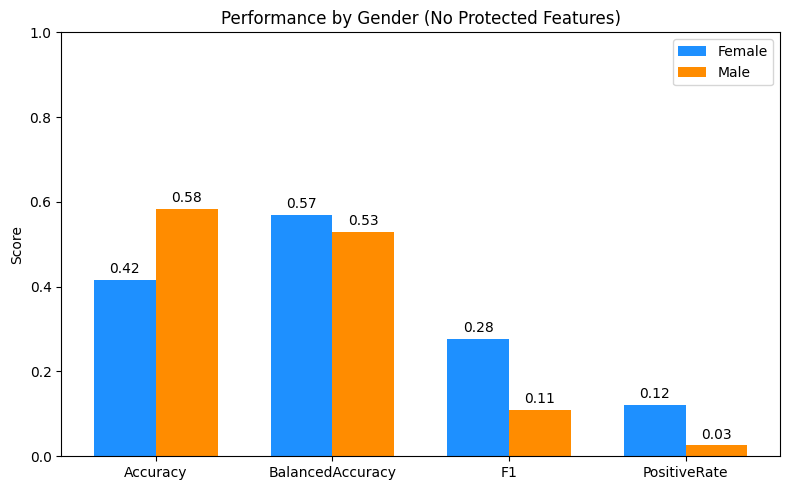

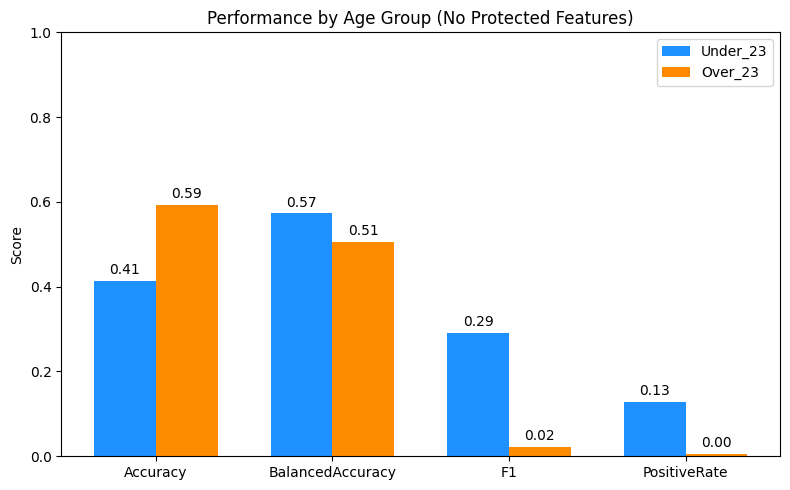

C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])


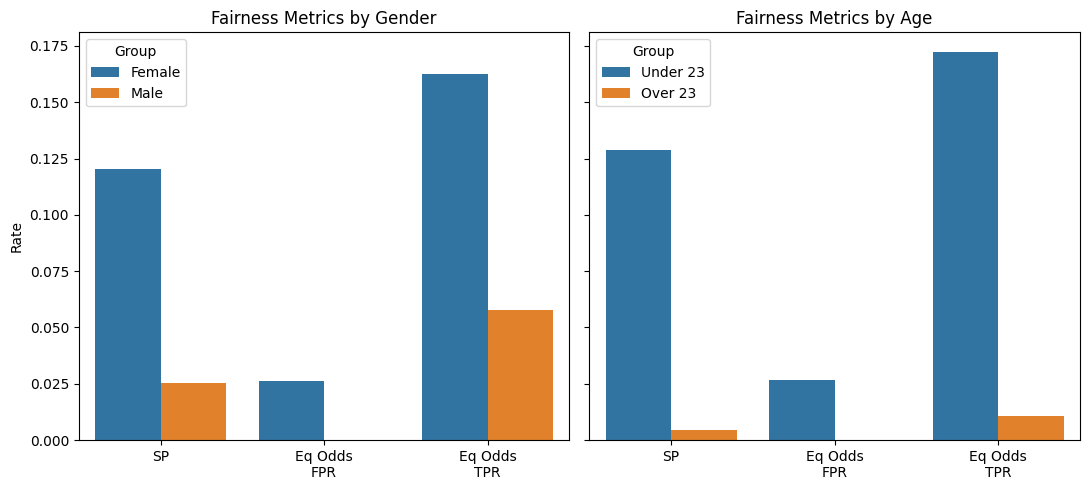

In [41]:
# Group metric plots
group_metrics_np = {m: {g: [] for g in ["Female", "Male", "Over_23", "Under_23"]} for m in ["F1", "Accuracy", "PositiveRate", "BalancedAccuracy"]}
group_test_dict = {
    "Female": X_test_scaled_final["Gender"] == 0,
    "Male": X_test_scaled_final["Gender"] == 1,
    "Under_23": X_test_scaled_final["Age at enrollment"] == 0,
    "Over_23": X_test_scaled_final["Age at enrollment"] == 1
}
for group, mask in group_test_dict.items():
    if mask.sum() == 0:
        continue
    group_metrics_np["F1"][group].append(f1_score(y_test_final[mask], y_pred_np[mask]))
    group_metrics_np["PositiveRate"][group].append(np.mean(y_pred_np[mask]))
    group_metrics_np["Accuracy"][group].append(accuracy_score(y_test_final[mask], y_pred_np[mask]))
    group_metrics_np["BalancedAccuracy"][group].append(balanced_accuracy_score(y_test_final[mask], y_pred_np[mask]))

plot_group_metrics(group_metrics_np, ["Female", "Male"], "Performance by Gender (No Protected Features)")
plot_group_metrics(group_metrics_np, ["Under_23", "Over_23"], "Performance by Age Group (No Protected Features)")

plot_fairness(fair_gender_np, fair_age_np)

# Fair PCA

In [42]:
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        Xs = Xs.values
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        Xs_p = Xs[:, p_idxs]
        R = scipy.linalg.null_space(Xs_p.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U

In [43]:
# Setup and train FairPCA model
p_idxs = [X.columns.get_loc("Gender"), X.columns.get_loc("Age at enrollment")]
fair_pca = FairPCA(X, p_idxs, n_components=30)
Xs_train_debiased = fair_pca.project(X)
Xs_test_debiased = fair_pca.project(X_test_scaled_final[X.columns])

C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\2139909660.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


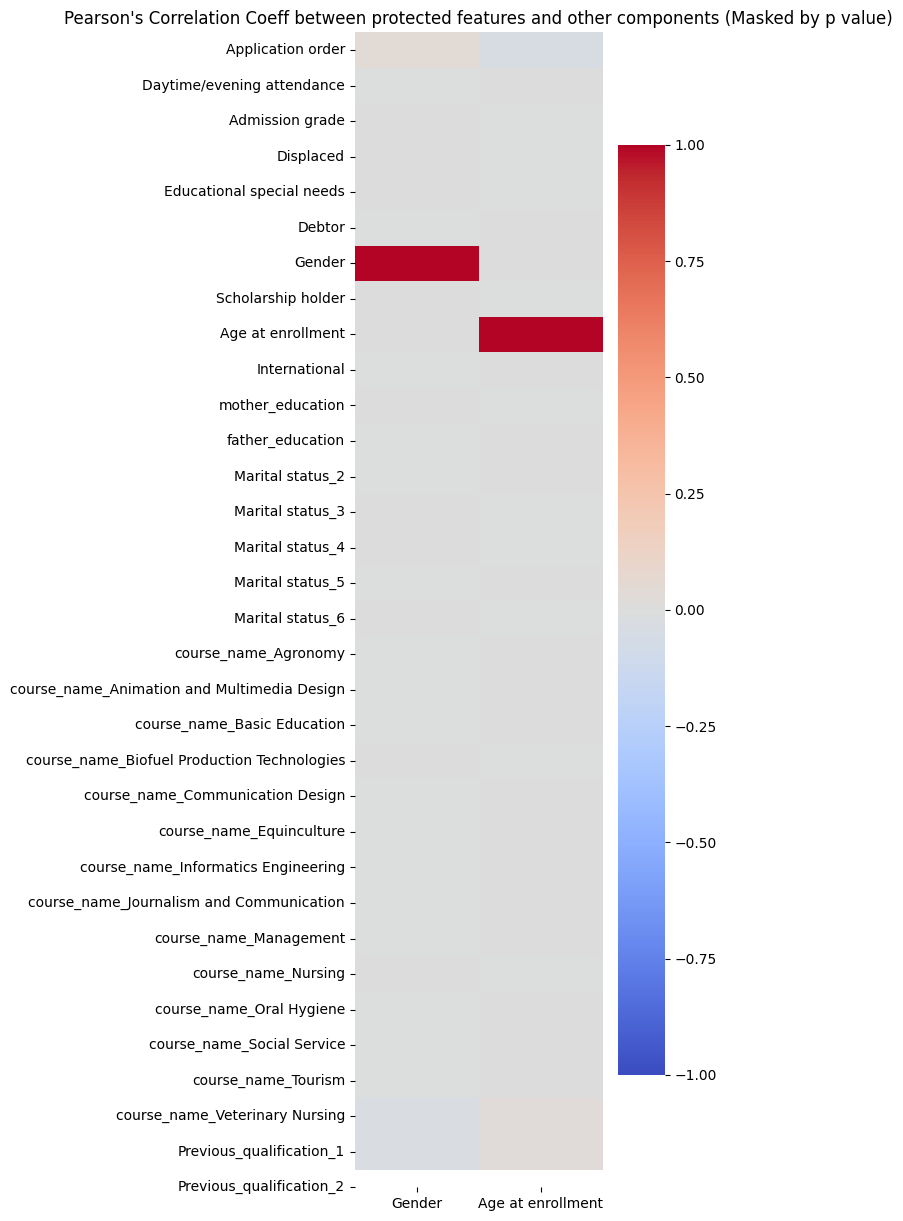

In [44]:
X_train_p = X[["Gender", "Age at enrollment"]].to_numpy()
Xs_train_debiased_p = np.concatenate([Xs_train_debiased, X_train_p], axis=1)
n_features = Xs_train_debiased_p.shape[1]
corr_ = np.zeros((n_features, n_features))
p_ = np.zeros((n_features, n_features))
for i in range(n_features):
    for j in range(n_features):
        corr_[i, j], p_[i, j] = pearsonr(Xs_train_debiased_p[:, i], Xs_train_debiased_p[:, j])
corr_ = np.nan_to_num(corr_, 0)

# Plot correlations with protected features (assumed at positions 6 and 8)
plt.figure(figsize=(4, 15))
sns.heatmap(
    corr_[:, [6, 8]], cmap="coolwarm",
    xticklabels=["Gender", "Age at enrollment"],
    yticklabels=X_train_scaled.columns,
    vmin=-1, vmax=1
)
plt.title("Pearson's Correlation Coeff between protected features and other components (Masked by p value)")
plt.tight_layout()
plt.show()


In [45]:
# Train model on debiased representation
model_pca = LogisticRegression(max_iter=5000, penalty=None)
model_pca.fit(Xs_train_debiased, y)
y_pred_pca = model_pca.predict(Xs_test_debiased)

In [46]:
# Evaluate
acc_pca = accuracy_score(y_test_final, y_pred_pca)
f1_pca = f1_score(y_test_final, y_pred_pca)
print(f"Accuracy (FairPCA): {acc_pca:.4f}")
print(f"F1 Score (FairPCA): {f1_pca:.4f}")

Accuracy (FairPCA): 0.5771
F1 Score (FairPCA): 0.4858


In [47]:
# Fairness metrics
fair_gender_pca = compute_fairness_metrics(
    pred=y_pred_pca,
    true=y_test_final,
    group_feature=X_test_scaled_final["Gender"],
    group_names=["Female", "Male"]
)
print("Fairness (Gender) - FairPCA:")
print(fair_gender_pca)

fair_age_pca = compute_fairness_metrics(
    pred=y_pred_pca,
    true=y_test_final,
    group_feature=X_test_scaled_final["Age at enrollment"],
    group_names=["Under 23", "Over 23"]
)
print("Fairness (Age) - FairPCA:")
print(fair_age_pca)

Fairness (Gender) - FairPCA:
                 Metric   Group     Score
0    Statistical Parity  Female  0.301426
1    Statistical Parity    Male  0.029787
2  FPR (Equalized Odds)  Female  0.065359
3  FPR (Equalized Odds)    Male  0.000000
4  TPR (Equalized Odds)  Female  0.408284
5  TPR (Equalized Odds)    Male  0.067308
Fairness (Age) - FairPCA:
                 Metric     Group     Score
0    Statistical Parity  Under 23  0.291751
1    Statistical Parity   Over 23  0.043668
2  FPR (Equalized Odds)  Under 23  0.060403
3  FPR (Equalized Odds)   Over 23  0.007407
4  TPR (Equalized Odds)  Under 23  0.390805
5  TPR (Equalized Odds)   Over 23  0.095745


In [48]:
# Group metrics
group_metrics_pca = {m: {g: [] for g in ["Female", "Male", "Over_23", "Under_23"]} for m in ["F1", "Accuracy", "PositiveRate", "BalancedAccuracy"]}
group_test_dict = {
    "Female": X_test_scaled_final["Gender"] == 0,
    "Male": X_test_scaled_final["Gender"] == 1,
    "Under_23": X_test_scaled_final["Age at enrollment"] == 0,
    "Over_23": X_test_scaled_final["Age at enrollment"] == 1
}
for group, mask in group_test_dict.items():
    if mask.sum() == 0:
        continue
    group_metrics_pca["F1"][group].append(f1_score(y_test_final[mask], y_pred_pca[mask]))
    group_metrics_pca["PositiveRate"][group].append(np.mean(y_pred_pca[mask]))
    group_metrics_pca["Accuracy"][group].append(accuracy_score(y_test_final[mask], y_pred_pca[mask]))
    group_metrics_pca["BalancedAccuracy"][group].append(balanced_accuracy_score(y_test_final[mask], y_pred_pca[mask]))


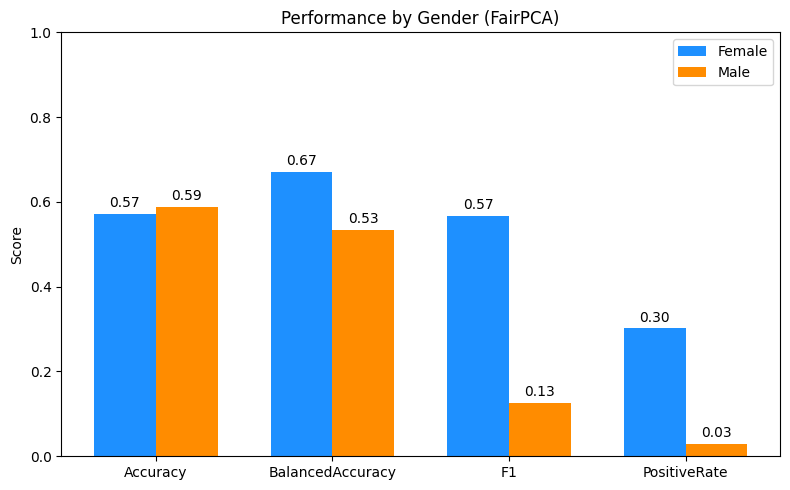

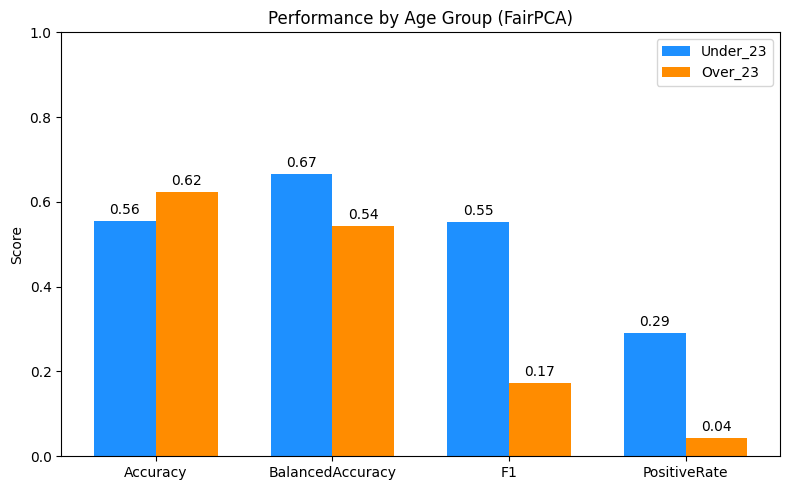

C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])


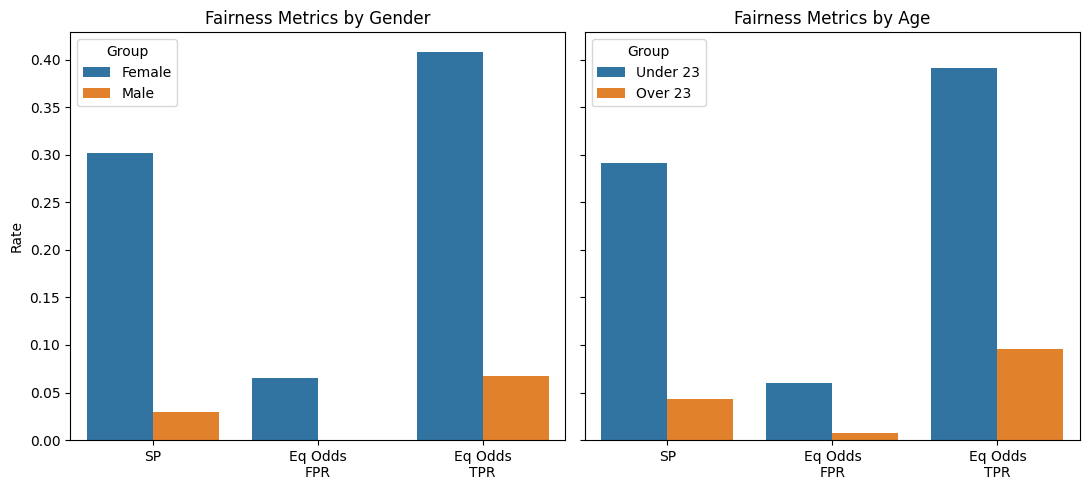

In [49]:
# Plots
plot_group_metrics(group_metrics_pca, ["Female", "Male"], "Performance by Gender (FairPCA)")
plot_group_metrics(group_metrics_pca, ["Under_23", "Over_23"], "Performance by Age Group (FairPCA)")
plot_fairness(fair_gender_pca, fair_age_pca)

# In-processing (custom loss)

In [50]:
# Define sigmoid function
def sigmoid(x):
    return 1. / (1 + np.exp(-x.astype(float)))

# Define logistic loss
def logistic_loss(y_true, y_pred, eps=1e-9):
    return -np.mean(y_true * np.log(y_pred + eps) + (1 - y_true) * np.log(1 - y_pred + eps))

# Define L2 regularization loss
def l2_loss(beta):
    return np.linalg.norm(beta, 2)

# Define fairness loss
def fair_loss_group(y, probs, groups, group_type):
    n1 = np.sum(groups == 0)
    n2 = np.sum(groups == 1)
    equal_pairs = np.argwhere(y[np.newaxis, :] == y[:, np.newaxis])
    equal_pairs = equal_pairs[equal_pairs[:, 0] != equal_pairs[:, 1]]
    diff_groups = (groups.iloc[equal_pairs[:, 0]].to_numpy() != groups.iloc[equal_pairs[:, 1]].to_numpy()).astype(int)
    diff_probs = probs.iloc[equal_pairs[:, 0]].to_numpy() - probs.iloc[equal_pairs[:, 1]].to_numpy()
    cost = diff_groups.dot(diff_probs) / (n1 * n2)
    return cost ** 2

# Define total cost function
def compute_cost(beta, X, y, groups, group_type, _lambda, _gamma):
    probs = sigmoid(X.dot(beta).astype(float))
    return logistic_loss(y, probs) + _lambda * fair_loss_group(y, probs, groups, group_type) + _gamma * l2_loss(beta[1:])

# Define gradient of the cost function
def compute_gradients(beta, X, y, groups, group_type, _lambda, _gamma):
    grad = np.zeros(beta.shape)
    m = len(X)
    probs = sigmoid(X.dot(beta).astype(float))
    for j in range(len(grad)):
        if j == 0:
            grad[j] = (1 / m) * (probs - y).dot(X.iloc[:, j])
        else:
            grad[j] = (1 / m) * (probs - y).dot(X.iloc[:, j]) + (2 * _gamma) * beta[j]
    return grad

In [51]:
# Fairness optimization for Gender
beta_init = np.random.rand(X_train_scaled.shape[1])
lambda_ = 0.1
gamma_ = 1e-5

In [52]:
result_gender, _, _ = opt.fmin_tnc(
    func=compute_cost,
    x0=beta_init,
    fprime=compute_gradients,
    args=(X_train_scaled, y_train, X_train_scaled["Gender"], "Gender", lambda_, gamma_),
    xtol=1e-7,
    ftol=1e-5
)
y_pred_fair_gender = (sigmoid(X_test_scaled @ result_gender) >= 0.5).astype(int)

C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\4218654604.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  equal_pairs = np.argwhere(y[np.newaxis, :] == y[:, np.newaxis])


In [53]:
# Fairness optimization for Age
beta_init = np.random.rand(X_train_scaled.shape[1])
result_age, _, _ = opt.fmin_tnc(
    func=compute_cost,
    x0=beta_init,
    fprime=compute_gradients,
    args=(X_train_scaled, y_train, X_train_scaled["Age at enrollment"], "Age", lambda_, gamma_),
    xtol=1e-7,
    ftol=1e-5
)
y_pred_fair_age = (sigmoid(X_test_scaled @ result_age) >= 0.5).astype(int)

C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\4218654604.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  equal_pairs = np.argwhere(y[np.newaxis, :] == y[:, np.newaxis])


In [54]:
# Evaluate overall performance
acc_fair_gender = accuracy_score(y_test, y_pred_fair_gender)
f1_fair_gender = f1_score(y_test, y_pred_fair_gender)
print(f"Accuracy (Fair Gender): {acc_fair_gender:.4f}")
print(f"F1 Score (Fair Gender): {f1_fair_gender:.4f}")

Accuracy (Fair Gender): 0.7493
F1 Score (Fair Gender): 0.7969


In [55]:
acc_fair_age = accuracy_score(y_test, y_pred_fair_age)
f1_fair_age = f1_score(y_test, y_pred_fair_age)
print(f"Accuracy (Fair Age): {acc_fair_age:.4f}")
print(f"F1 Score (Fair Age): {f1_fair_age:.4f}")

Accuracy (Fair Age): 0.7493
F1 Score (Fair Age): 0.7969


In [56]:
# Compute fairness metrics
fair_gender_in_processing = compute_fairness_metrics(
    pred=y_pred_fair_gender,
    true=y_test,
    group_feature=X_test_scaled["Gender"],
    group_names=["Female", "Male"]
)
print("Fairness (Gender) - In-Processing:")
print(fair_gender_in_processing)

Fairness (Gender) - In-Processing:
                 Metric   Group     Score
0    Statistical Parity  Female  0.757637
1    Statistical Parity    Male  0.348936
2  FPR (Equalized Odds)  Female  0.490196
3  FPR (Equalized Odds)    Male  0.167939
4  TPR (Equalized Odds)  Female  0.878698
5  TPR (Equalized Odds)    Male  0.576923


In [57]:
fair_age_in_processing = compute_fairness_metrics(
    pred=y_pred_fair_age,
    true=y_test,
    group_feature=X_test_scaled["Age at enrollment"],
    group_names=["Under 23", "Over 23"]
)
print("Fairness (Age) - In-Processing:")
print(fair_age_in_processing)

Fairness (Age) - In-Processing:
                 Metric     Group     Score
0    Statistical Parity  Under 23  0.790744
1    Statistical Parity   Over 23  0.266376
2  FPR (Equalized Odds)  Under 23  0.510067
3  FPR (Equalized Odds)   Over 23  0.155556
4  TPR (Equalized Odds)  Under 23  0.910920
5  TPR (Equalized Odds)   Over 23  0.425532


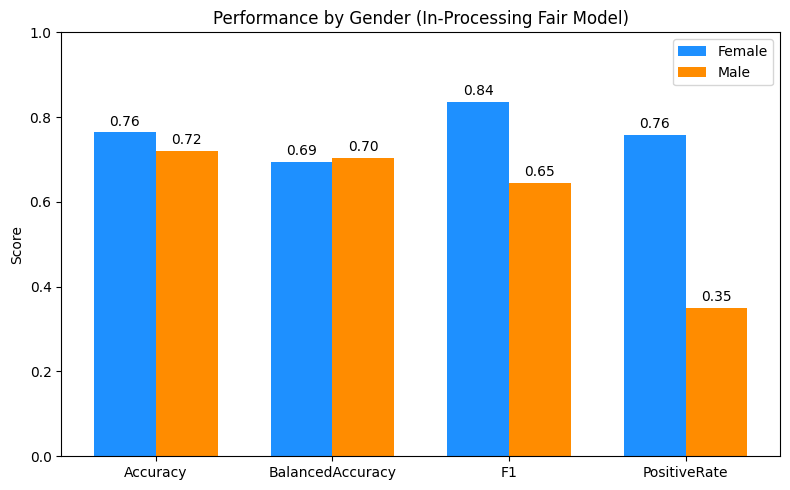

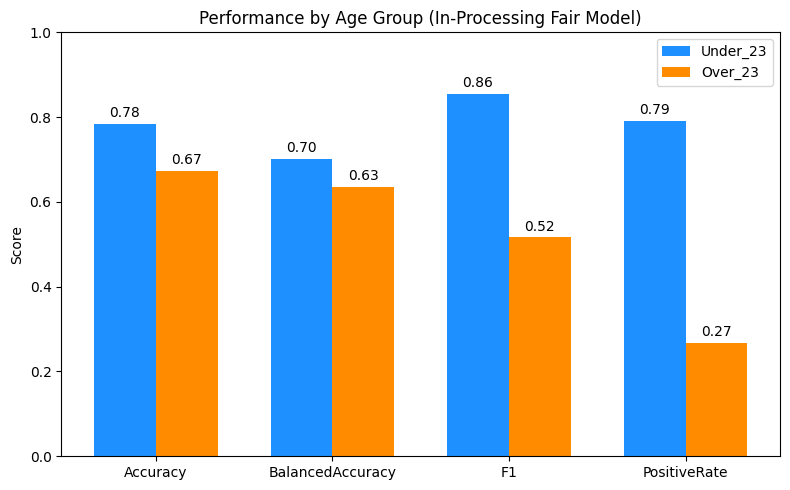

In [58]:
# Group Performance Metrics (In-Processing)
group_metrics_fair_gender = {m: {g: [] for g in ["Female", "Male"]} for m in ["F1", "Accuracy", "PositiveRate", "BalancedAccuracy"]}
for group in ["Female", "Male"]:
    g_val = 0 if group == "Female" else 1
    mask = X_test_scaled["Gender"] == g_val
    group_metrics_fair_gender["F1"][group].append(f1_score(y_test[mask], y_pred_fair_gender[mask]))
    group_metrics_fair_gender["Accuracy"][group].append(accuracy_score(y_test[mask], y_pred_fair_gender[mask]))
    group_metrics_fair_gender["PositiveRate"][group].append(np.mean(y_pred_fair_gender[mask]))
    group_metrics_fair_gender["BalancedAccuracy"][group].append(balanced_accuracy_score(y_test[mask], y_pred_fair_gender[mask]))

plot_group_metrics(group_metrics_fair_gender, ["Female", "Male"], "Performance by Gender (In-Processing Fair Model)")

group_metrics_fair_age = {m: {g: [] for g in ["Under_23", "Over_23"]} for m in ["F1", "Accuracy", "PositiveRate", "BalancedAccuracy"]}
for group in ["Under_23", "Over_23"]:
    g_val = 0 if group == "Under_23" else 1
    mask = X_test_scaled["Age at enrollment"] == g_val
    group_metrics_fair_age["F1"][group].append(f1_score(y_test[mask], y_pred_fair_age[mask]))
    group_metrics_fair_age["Accuracy"][group].append(accuracy_score(y_test[mask], y_pred_fair_age[mask]))
    group_metrics_fair_age["PositiveRate"][group].append(np.mean(y_pred_fair_age[mask]))
    group_metrics_fair_age["BalancedAccuracy"][group].append(balanced_accuracy_score(y_test[mask], y_pred_fair_age[mask]))

plot_group_metrics(group_metrics_fair_age, ["Under_23", "Over_23"], "Performance by Age Group (In-Processing Fair Model)")

C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])


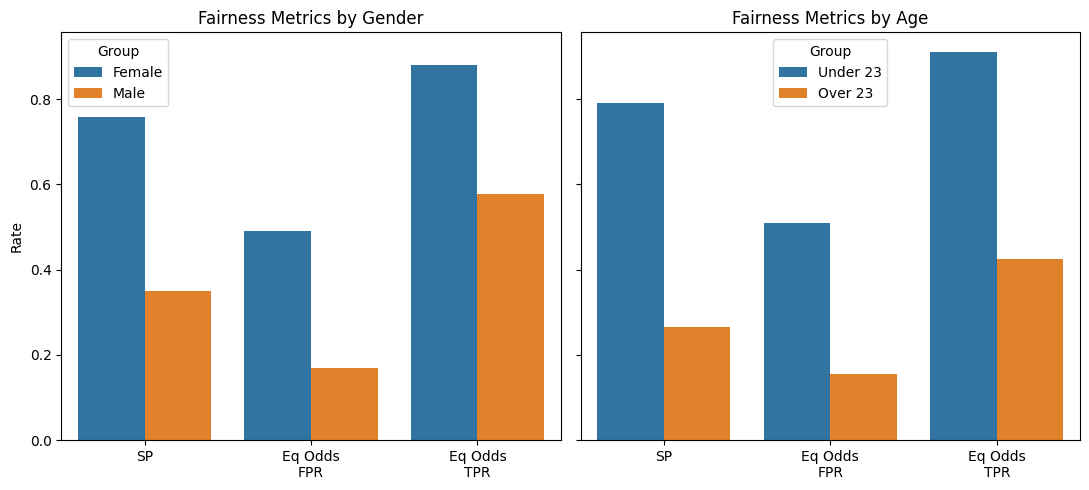

In [59]:
# Fairness plots
plot_fairness(fair_gender_in_processing, fair_age_in_processing)

#  Post-processing (Group thresholds)

In [61]:
def roc_curve_generator(test, prob):
    fpr, tpr, thr = roc_curve(test, prob, drop_intermediate=False)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def roc_curve_generator_groups(y_true1, prob1, y_true2, prob2, group1_name, group2_name):
    fpr1, tpr1, thr1 = roc_curve(y_true1, prob1, drop_intermediate=False)
    fpr2, tpr2, thr2 = roc_curve(y_true2, prob2, drop_intermediate=False)
    tpr_diff = []
    fpr_diff = []
    thresholds = []
    for p in np.arange(0.1, 0.99, 0.001):
        try:
            idx1 = np.where(tpr1 > p)[0][0]
            idx2 = np.where(tpr2 > p)[0][0]
        except IndexError:
            continue
        tpr_diff.append(abs(tpr1[idx1] - tpr2[idx2]))
        fpr_diff.append(abs(fpr1[idx1] - fpr2[idx2]))
        thresholds.append((thr1[idx1], thr2[idx2]))
    if not thresholds:
        print("No threshold found with TPR > 0.1 for both groups.")
        return None, None
    diffs = [abs(f - t) for f, t in zip(fpr_diff, tpr_diff)]
    n = np.argmin(diffs)
    thr_group1, thr_group2 = thresholds[n]
    plt.figure(figsize=(7, 5))
    plt.plot(fpr1, tpr1, label=group1_name)
    plt.plot(fpr2, tpr2, label=group2_name)
    plt.title("ROC Curves by Group")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return thr_group1, thr_group2

In [62]:
prob = final_model.predict_proba(X_test_scaled_final)[:, 1]

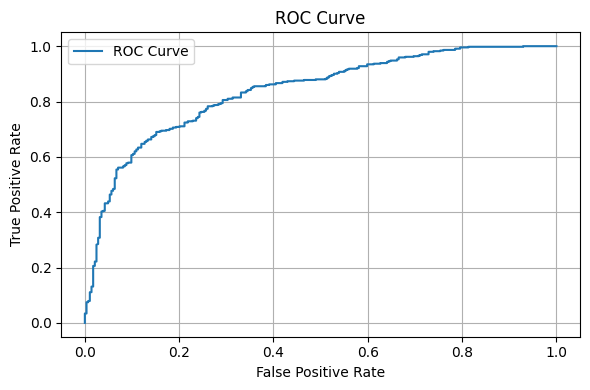

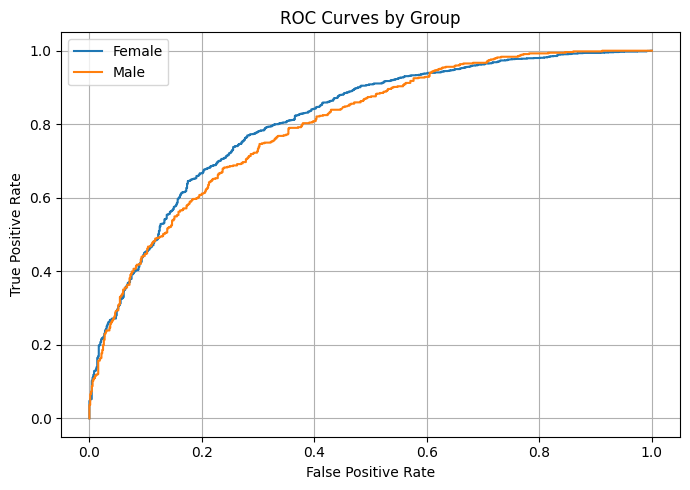

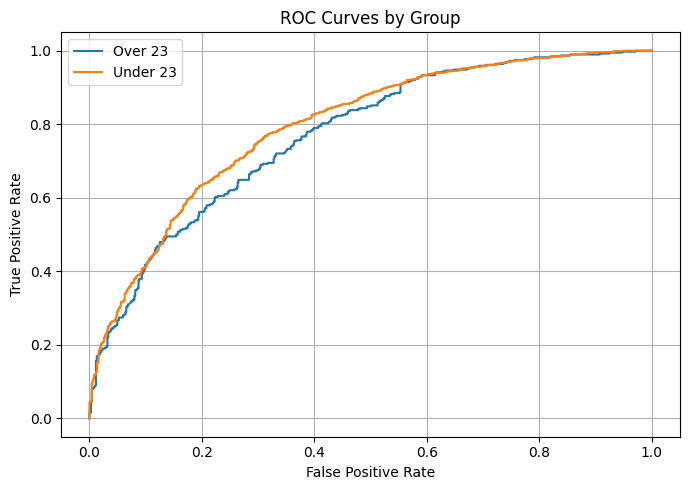

In [63]:
roc_curve_generator(y_test_final, prob)
log_y_prob_female = final_model.predict_proba(X_scaled[X_scaled["Gender"]==0])[:, 1]
log_y_prob_male = final_model.predict_proba(X_scaled[X_scaled["Gender"]==1])[:, 1]
log_thr_female, log_thr_male = roc_curve_generator_groups(
    y[y.index.isin(X_scaled[X_scaled["Gender"]==0].index)], log_y_prob_female,
    y[y.index.isin(X_scaled[X_scaled["Gender"]==1].index)], log_y_prob_male,
    "Female", "Male"
)
log_y_prob_old = final_model.predict_proba(X_scaled[X_scaled["Age at enrollment"]==1])[:, 1]
log_y_prob_young = final_model.predict_proba(X_scaled[X_scaled["Age at enrollment"]==0])[:, 1]
log_thr_old, log_thr_young = roc_curve_generator_groups(
    y[y.index.isin(X_scaled[X_scaled["Age at enrollment"]==1].index)], log_y_prob_old,
    y[y.index.isin(X_scaled[X_scaled["Age at enrollment"]==0].index)], log_y_prob_young,
    "Over 23", "Under 23"
)


In [64]:
print(f"Optimal Gender Thresholds: Female: {log_thr_female:.3f}, Male: {log_thr_male:.3f}")
print(f"Optimal Age Thresholds: Over 23: {log_thr_old:.3f}, Under 23: {log_thr_young:.3f}")


Optimal Gender Thresholds: Female: 0.897, Male: 0.745
Optimal Age Thresholds: Over 23: 0.570, Under 23: 0.857


In [65]:
def new_accuracy(y_prob, y_true, group_feature, thr_0, thr_1, group_names=("Group 0", "Group 1")):
    group_0_mask = group_feature == 0
    group_1_mask = group_feature == 1
    new_pred = np.where(group_0_mask, (y_prob >= thr_0).astype(int), (y_prob >= thr_1).astype(int))
    df = pd.DataFrame({"group": group_feature, "y_true": y_true, "pred": new_pred})
    stat_parity_0 = df.loc[df["group"] == 0, "pred"].mean()
    stat_parity_1 = df.loc[df["group"] == 1, "pred"].mean()
    eq_odds_t0_0 = df.loc[(df["group"] == 0) & (df["y_true"] == 0), "pred"].mean()
    eq_odds_t0_1 = df.loc[(df["group"] == 1) & (df["y_true"] == 0), "pred"].mean()
    eq_odds_t1_0 = df.loc[(df["group"] == 0) & (df["y_true"] == 1), "pred"].mean()
    eq_odds_t1_1 = df.loc[(df["group"] == 1) & (df["y_true"] == 1), "pred"].mean()
    scores = [
        (stat_parity_0, stat_parity_1),
        (eq_odds_t0_0, eq_odds_t0_1),
        (eq_odds_t1_0, eq_odds_t1_1)
    ]
    metric_names = ["Statistical Parity", "FPR (Equalized Odds)", "TPR (Equalized Odds)"]
    records = []
    for metric, (s0, s1) in zip(metric_names, scores):
        records.append({"Metric": metric, "Group": group_names[0], "Score": s0})
        records.append({"Metric": metric, "Group": group_names[1], "Score": s1})
    df_fair = pd.DataFrame(records)
    acc = accuracy_score(y_true, new_pred)
    f1 = f1_score(y_true, new_pred)
    return f1, acc, df_fair

In [66]:
# Apply thresholds
new_log_f1_gender, new_log_accuracy_gender, new_log_fairness_gender = new_accuracy(
    y_prob=prob,
    y_true=y_test_final,
    group_feature=X_test_scaled_final["Gender"],
    thr_0=log_thr_female,
    thr_1=log_thr_male,
    group_names=("Female", "Male")
)
new_log_f1_age, new_log_accuracy_age, new_log_fairness_age = new_accuracy(
    y_prob=prob,
    y_true=y_test_final,
    group_feature=X_test_scaled_final["Age at enrollment"],
    thr_0=log_thr_young,
    thr_1=log_thr_old,
    group_names=("Under 23", "Over 23")
)

In [67]:
print(f"Post-processed Accuracy (Gender): {new_log_accuracy_gender:.4f}")
print(f"Post-processed Accuracy (Age): {new_log_accuracy_age:.4f}")
print(f"Post-processed F1 (Gender): {new_log_f1_gender:.4f}")
print(f"Post-processed F1 (Age): {new_log_f1_age:.4f}")

Post-processed Accuracy (Gender): 0.5455
Post-processed Accuracy (Age): 0.6088
Post-processed F1 (Gender): 0.4271
Post-processed F1 (Age): 0.5576


C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])
C:\Users\Mikas\AppData\Local\Temp\ipykernel_5344\1833316189.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['SP', 'Eq Odds\nFPR', 'Eq Odds\nTPR'])


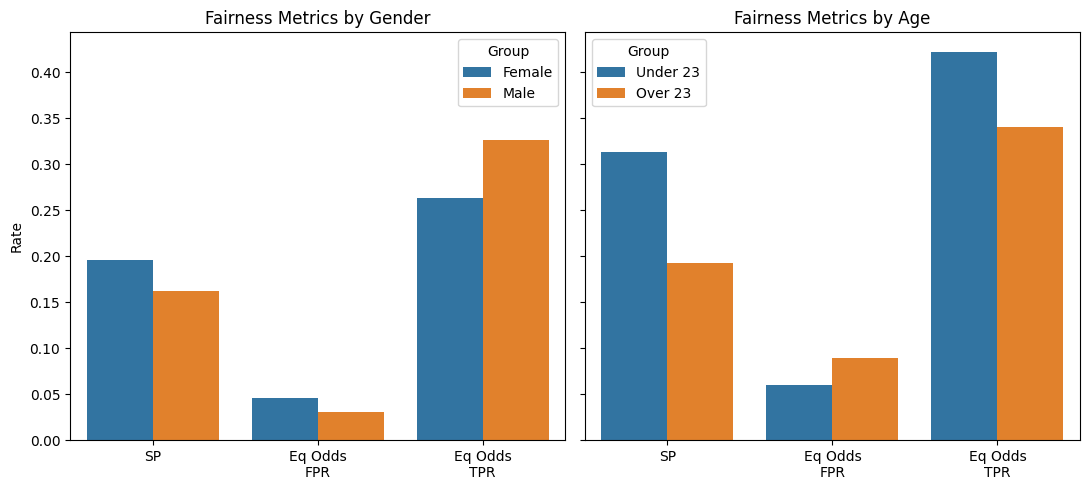

In [68]:
plot_fairness(new_log_fairness_gender, new_log_fairness_age)